# Measuring class label shift

In [1]:
import matplotlib.pyplot as plt

from csbm import MultiClassCSBM, ClassLabelCSBM
from metrics import total_variation_distance

In [2]:
n = 80
c = 8
t = 17

In [4]:
csbm = MultiClassCSBM(n=n, classes=c)
csbm_class = ClassLabelCSBM(n=n, classes=c)

initial_p = csbm_class.p
current_p = [0] * c
for label in csbm.y:
    current_p[label] += 1

time_steps = [1]
tvd_const = [csbm.get_class_label_shift_tvd()]
tvd_class = [csbm_class.get_class_label_shift_tvd()]
tvd_p = [total_variation_distance(initial_p, csbm_class.p)]
tvd_total = [total_variation_distance([label / n for label in current_p], [label / n for label in current_p])]

In [5]:
for tau in range(2, t + 1):
    time_steps.append(tau)
    
    csbm.evolve()
    tvd_const.append(csbm.get_class_label_shift_tvd())

    csbm_class.evolve()
    tvd_class.append(csbm_class.get_class_label_shift_tvd())
    tvd_p.append(total_variation_distance(initial_p, csbm_class.p))
    for label in csbm_class.y[-n:]:
        current_p[label] += 1
    tvd_total.append(total_variation_distance(initial_p, [label / tau / n for label in current_p]))

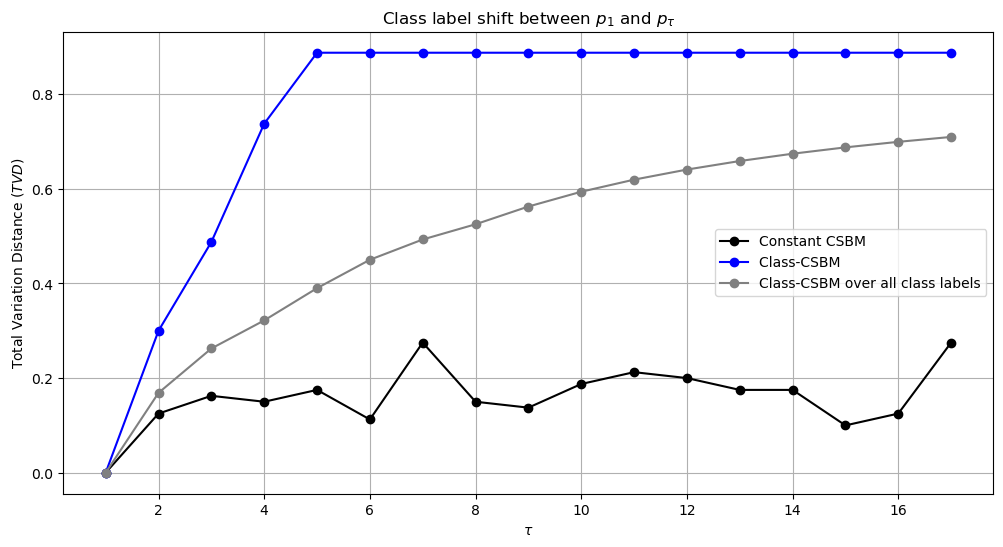

In [12]:
plt.figure(figsize=(12, 6))
plt.title(r'Class label shift between $p_{1}$ and $p_{\tau}$')
plt.plot(time_steps, tvd_const, marker='o', linestyle='-', color='black', label='Constant CSBM')
plt.plot(time_steps, tvd_class, marker='o', linestyle='-', color='b', label=r'Class-CSBM ')
plt.plot(time_steps, tvd_total, marker='o', linestyle='-', color='gray', label='Class-CSBM over all class labels')
plt.xlabel(r'$\tau$')
plt.ylabel('Total Variation Distance $(TVD)$')
plt.grid(True)
plt.legend(loc='center right')
plt.savefig('class_label_shift.pdf', format='pdf')
plt.show()